# Homework \#2

## Problem 1 - Blending AvGas

* produces two main types of fuel: Jet A and 100LL
* a set of raw inputs (different grades of petroleum) $P$
* A subset of these inputs - $P_T$ - must be treated with chemicals
e.g. the process to create 20 gallons of 100LL 
    1. could be 10 gallons of raw input 1 and 10 gallons of raw input 2  
       ->blend  
       ->20 gallons of 100LL
    2. If a raw input belongs to the set $P_T$ (e.g., raw input 1), the process could be 10 gallons raw input 1  
       ->treat raw input 1  
       ->blend 10 gallons (treated) raw input 1 and 10 gallons raw input 2  
       ->20 gallons 100LL  
* For each raw input $p \in P$, there is a maximum number of gallons available for purchase, $u_p$   
* The inputs cost $c_p$ dollars per gallon for each $p \in P$  
*  a cost per gallon associated with each step of the production process: $\alpha_{treat}$, $\alpha_{jetAprod}$, $\alpha_{100LLprod}$, $\alpha_{blend}$  .
* a set of requirements $R$ such that for each $r \in R$, both Jet A and 100LL must meet a minimum of $b_r$ percentage of the final product.
* For each raw input $p \in P$, we know that $p$ contains $a_{pr}$ of requirement $r \in R$   
* a daily demand for $D_1$ gallons of Jet A and $D_2$ gallons of 100LL  

**Formulate a linear programming model that minimizes the cost of meeting demand.**

* var:
    * ri[i, t]

* const:
    * ri[i, t] <= avai_pur[i]
    * sum(ri[i, t] * req_per[i]) >= min_per
    * sum(ri[i, t]) = dem[t]

* obj:
    * Min c_ri[i] + c_pp[i, t]
    * c_ri = ri[i, t] * c_riper[i]
    * c_pp = ri_sub * treat + prod[t] + if(count(ri) > 1) blend


In [1]:
using Random

P = 17 # number of raw inputs
T = 6 # number raw inputs that must be treated

inputs = 1:P # set of raw inputs
treat = 1:T # for simplicity, first T inputs must be treated
outputs = 1:2 # set of products

# production costs (per gallon)
treat_cost = 2.0
blend_cost = 1.5
jetA_prod_cost = 3.0
onehunLL_prod_cost = 2.4

# set a seed for generating consistent data
seed = 9834573
Random.seed!(seed)

# demand for each product
demand = [Random.rand(5000:10000) for j in outputs]

# cost of each input ($/gallon)
rm_cost = [Random.rand(1:5) for i in inputs]

# availability of each input (gallons)
avail = [Random.rand(1000:8000) for i in inputs]

# percent of requirement 1 in each input
req1_per = [round(2.0*Random.rand()+5,digits=2) for i in inputs]
# percent of requirement 2 in each input
req2_per = [round(4*Random.rand()+3,digits=2) for i in inputs]

# max percent of requirement 1 in each output
req1_lim = 5.5
# max percent of requirement 2 in each output
req2_lim = 5.9;

In [2]:
using JuMP, Clp, NamedArrays

m = Model(Clp.Optimizer)
# raw input usage for diff output
@variable(m, x[inputs, outputs] >= 0)

# raw input <= availability
@constraint(m, con_avail[i in inputs], sum(x[i, o] for o in outputs) <= avail[i])
# ??? how to know when to use "<=/ >=" or "=" 

# sum of req1/ req2 in each input >= min req1/ req2
@constraint(m, con_req1[o in outputs], sum(x[i, o] * req1_per[i] for i in inputs) >= req1_lim)
@constraint(m, con_req2[o in outputs], sum(x[i, o] * req2_per[i] for i in inputs) >= req2_lim)
# ??? how to know where to put "for_in" (with constraint name or in expression) 

# sum of raw input = demand
@constraint(m, con_dem[o in outputs], sum(x[i, o] for i in inputs) == demand[o])

# input cost + treat cost + blend cost + jetA production cost + onehunLL production cost
# ??? how to know if there is blend if it is possible
@expression(m, cost_input, sum(x[i, o] * rm_cost[i] for i in inputs, o in outputs))
@expression(m, cost_treat, sum(x[i, o] * treat_cost for i in treat, o in outputs))
@expression(m, cost_blend, sum(x[i, o] * blend_cost for i in inputs, o in outputs))
@expression(m, cost_jet_prod, sum(x[i, 1] * jetA_prod_cost for i in inputs))
# ??? = demand * prod_cost
@expression(m, cost_one_prod, sum(x[i, 2] * onehunLL_prod_cost for i in inputs))
@objective(m, Min, cost_input + cost_treat + cost_blend + cost_jet_prod + cost_one_prod)

optimize!(m)
println("Total cost will be \$", objective_value(m))
println()
solution = NamedArray( 
    Int[value(x[i,o]) for i in inputs, o in outputs], 
    (inputs,outputs), 
    ("inputs","outputs") 
)

Total cost will be $69322.40000000001

Coin0506I Presolve 23 (0) rows, 34 (0) columns and 136 (0) elements
Clp0006I 0  Obj 0 Primal inf 13493.287 (6)
Clp0006I 5  Obj 69322.4
Clp0000I Optimal - objective value 69322.4
Clp0032I Optimal objective 69322.4 - 5 iterations time 0.002


17×2 Named Matrix{Int64}
inputs ╲ outputs │    1     2
─────────────────┼───────────
1                │    0     0
2                │    0     0
3                │    0     0
4                │    0     0
5                │    0     0
6                │    0     0
7                │    0     0
8                │    0  4264
9                │ 4115  3857
10               │    0     0
11               │    0     0
12               │    0     0
13               │    0     0
14               │    0     0
15               │    0     0
16               │    0     0
17               │ 1254     0

## Problem 2 - Brew$^2$

* determine a production schedule in order to meet projected demand for their most popular beer LPA over the next 6 months.
* It costs \\$40 to produce one keg of LPA V
* It costs \\$10 per keg per month to store it in inventory. The brewery currently has 15 kegs of LPA in inventory. V
* anything left after month 6 will be sold to wholesalers at \\$30 per keg. V
* A vat can produce up to 10 kegs per month. V
* The brewery has the option to either purchase a vat (\\$5000 per vat) or lease a vat (\\$350 per month). V
* Used vats sell for \\$4500 per vat. V
* Owning a vat incurs a \\$50 per month maintenance cost (per vat). V
* Assume vats can be purchased, sold, or leased only at the beginning of each month. The brewery currently owns 3 vats, and they would also like to own at least 3 vats at the end of month 6.  

**(a) Formulate a linear program to help the brewery minimize its net cost while meeting demand over the next 6 months. Solve the model in Julia/JuMP and display the production plan (how many kegs to produce each month, how many vats to buy, sell, lease each month). Does your solution make sense?**  

* var:
    * x_t: # of LPA to produce in month t = 1, … , 6
    * i_t: Ending inventory of LPA in month t = 0,1, … , 6 (i_t[0] = 15)
    * v_t: # vat available in month t = 0,1, … , 6 (v_t[0] = 3, v_t [6] >= 3)
    * vp_t: # vat purchased at the beginning of month t = 1, … , 6
    * vl_t: # vat leased at the beginning of month t = 1, … , 6
    * vs_t: # vat sold at the beginning of month t = 1, … , 6

* obj:
    * x_t * c_prod (40)
    * i_t * c_inv (10)
    * i_t[6] * e_left (-30)
    * v_t * c_main (50)
    * vp_t * c_pur (5000)
    * vl_t * c_leas (350)
    * vs_t * e_sold (-4500)

* const:
    * x_t <= v_t * v_prod (10), t = 1, … , 6
    * i_t-1 + x_t = dt + i_t, t = 1, … , 6
    * v_t = v_t-1 + vp_t + vl_t – vs_t


In [3]:
using JuMP, Clp

d = [60 50 80 70 90 50] # monthly LPA demand

m = Model(Clp.Optimizer)

c_prod = 40
c_inv = 10
e_left = 30
c_main = 50
c_pur = 5000
c_leas = 350
e_sold = 4500
v_prod = 10
i_init = 15
v_init = 3
v_final = 3

@variable(m, x[1:6] >= 0) # of LPA to produce in month t = 1, … , 6
@variable(m, i[1:6] >= 0) # Ending inventory of LPA in month t = 1, … , 6 (i_t[0] = 15)
@variable(m, v[1:6] >= 0) # vat available in month t = 1, … , 6 (v_t[0] = 3, v_t [6] = 3)
@variable(m, vp[1:6] >= 0) # vat purchased at the beginning of month t = 1, … , 6
@variable(m, vl[1:6] >= 0) # vat leased at the beginning of month t = 1, … , 6
@variable(m, vs[1:6] >= 0) # vat sold at the beginning of month t = 1, … , 6

# objective is to minimize the total cost
# without inventory cost i[0], with i[6], without maintenance cost v[0] 
# @objective(m, Min, c_prod*sum(x) + c_inv*sum(i) + c_main*sum(v) + c_pur*sum(vp)
#     + c_leas*sum(vl) + e_sold*sum(vs) + e_left*i[6])
@objective(m, Min, c_prod*sum(x) + c_inv*sum(i) + c_main*sum(v) + c_pur*sum(vp)
    + c_leas*sum(vl))

@constraint(m, prod[t in 1:6], x[t] <= v[t] * v_prod) # of LPA production
@constraint(m, inv_init, i_init + x[1] == d[1] + i[1]) # inventory in the first month 
@constraint(m, inv[t in 2:6], i[t-1] + x[t] == d[t] + i[t]) # inventory in all months after the first
@constraint(m, vat_init, v_init + vp[1] + vl[1] - vs[1] == v[1]) # vat in the first month 
@constraint(m, vat[t in 2:6], v[t-1] + vp[t] + vl[t] - vs[t] == v[t]) # vat in some months after the first
@constraint(m, vat_final, v_final <= v[6]) # vat in the final month

optimize!(m)

println("Produce ", Array(value.(x')), " kegs of LPA each month")
println(Array(value.(i')), " kegs of LPA in the inventory each month")
println("Use ", Array(value.(v)), " vats each month")
println("Purchase ", Array(value.(vp)), " vats each month")
println("Lease ", Array(value.(vl)), " vats each month")
println("Sell ", Array(value.(vs)), " vats each month")
println(value.(i[6]), " kegs of LPA left in the end")
println(value.(v[6]), " vats left in the end")
println("Cost: ", objective_value(m))
println("Net Cost: ", objective_value(m) - e_sold*sum(value.(vs)) - e_left*(value.(i[6])))

Produce [45.0 50.0 80.0 79.99999999999999 80.0 50.0] kegs of LPA each month
[0.0 0.0 0.0 9.99999999999999 0.0 0.0] kegs of LPA in the inventory each month
Use [4.5, 5.0, 8.0, 7.999999999999998, 8.0, 5.0] vats each month
Purchase [0.0, 0.0, 0.0, 0.0, 0.0, 0.0] vats each month
Lease [1.4999999999999998, 0.5000000000000003, 2.9999999999999987, 0.0, 0.0, 0.0] vats each month
Sell [0.0, 0.0, 0.0, 0.0, 0.0, 3.0] vats each month
0.0 kegs of LPA left in the end
5.0 vats left in the end
Cost: 19175.0
Net Cost: 5675.0
Coin0506I Presolve 17 (-2) rows, 23 (-13) columns and 44 (-15) elements
Clp0006I 0  Obj 2660 Primal inf 259.28082 (7)
Clp0006I 22  Obj 19175
Clp0000I Optimal - objective value 19175
Coin0511I After Postsolve, objective 19175, infeasibilities - dual 0 (0), primal 0 (0)
Clp0032I Optimal objective 19175 - 22 iterations time 0.002, Presolve 0.00


**🠊 The solution does not make sense because the number of vats should be an integer, but we have results indicating the need to lease 1.5 vats.**

**(b) Now suppose the brewery would like to allow backlogging of demand. Demand not met in a month may be met in a future month (backlogged). The brewery pays a fee of \\$19 per keg per month backlogged. Modify your code from part (a) to include the ability to backlog. All demand should be met by the end of month 6. How, if at all, does this change the optimal objective value and solution? Speculate as to the reason for the change (or lack of change).**

In [4]:
using JuMP, Clp

d = [60 50 80 70 90 50] # monthly LPA demand

m = Model(Clp.Optimizer)

c_prod = 40
c_inv = 10
c_back = 19
e_left = 30
c_main = 50
c_pur = 5000
c_leas = 350
e_sold = 4500
v_prod = 10
i_init = 15
v_init = 3
v_final = 3

@variable(m, x[1:6] >= 0) # LPA to produce in month t = 1, … , 6
@variable(m, i[1:6] >= 0) # Ending inventory of LPA in month t = 1, … , 6 (i_t[0] = 15) (can be negative)
@variable(m, v[1:6] >= 0) # vat available in month t = 1, … , 6 (v_t[0] = 3, v_t [6] = 3)
@variable(m, vp[1:6] >= 0) # vat purchased at the beginning of month t = 1, … , 6
@variable(m, vl[1:6] >= 0) # vat leased at the beginning of month t = 1, … , 6
@variable(m, vs[1:6] >= 0) # vat sold at the beginning of month t = 1, … , 6
@variable(m, L[1:6] >= 0 ) # LPA leftover in month
@variable(m, S[1:6] >= 0 ) # LPA backlogged in month

# objective is to minimize the total cost
@objective(m, Min, c_prod*sum(x) + c_inv*sum(L) + c_back*sum(S) + c_main*sum(v) + c_pur*sum(vp)
    + c_leas*sum(vl))

@constraint(m, prod[t in 1:6], x[t] <= v[t] * v_prod) # LPA production
# constraint that requires inventory to be the difference between leftovers and shortage each month
@constraint(m, inv_ident[t in 1:6], i[t] == L[t] - S[t])
@constraint(m, i[6] >= 0) # enforce that all demand is met eventually
@constraint(m, inv_init, i_init + x[1] == d[1] + i[1]) # inventory in the first month 
@constraint(m, inv[t in 2:6], i[t-1] + x[t] == d[t] + i[t]) # inventory in all months after the first
@constraint(m, vat_init, v_init + vp[1] + vl[1] - vs[1] == v[1]) # vat in the first month 
@constraint(m, vat[t in 2:6], v[t-1] + vp[t] + vl[t] - vs[t] == v[t]) # vat in some months after the first
@constraint(m, vat_final, v_final <= v[6]) # vat in the final month

optimize!(m)

println("Produce ", Array(value.(x')), " kegs of LPA each month")
println(Array(value.(i')), " kegs of LPA in the inventory each month")
println("Backlog: ", Array(value.(S)))
println("Use ", Array(value.(v)), " vats each month")
println("Purchase ", Array(value.(vp)), " vats each month")
println("Lease ", Array(value.(vl)), " vats each month")
println("Sell ", Array(value.(vs)), " vats each month")
println("Cost: ", objective_value(m))
println("Net Cost: ", objective_value(m) - e_sold*sum(value.(vs)) - e_left*(value.(i[6])))

Produce [45.0 50.0 80.0 79.99999999999999 80.0 50.0] kegs of LPA each month
[0.0 0.0 0.0 9.99999999999999 0.0 0.0] kegs of LPA in the inventory each month
Backlog: [0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
Use [4.5, 5.0, 8.0, 7.999999999999998, 8.0, 5.0] vats each month
Purchase [0.0, 0.0, 0.0, 0.0, 0.0, 0.0] vats each month
Lease [1.4999999999999998, 0.5000000000000003, 2.9999999999999987, 0.0, 0.0, 0.0] vats each month
Sell [0.0, 0.0, 0.0, 0.0, 0.0, 3.0] vats each month
Cost: 19175.0
Net Cost: 5675.0
Coin0506I Presolve 17 (-9) rows, 23 (-25) columns and 44 (-34) elements
Clp0006I 0  Obj 2660 Primal inf 259.28082 (7)
Clp0006I 22  Obj 19175
Clp0000I Optimal - objective value 19175
Coin0511I After Postsolve, objective 19175, infeasibilities - dual 0 (0), primal 0 (0)
Clp0032I Optimal objective 19175 - 22 iterations time 0.002, Presolve 0.00


**🠊 The ability to backlog does not change the optimal objective value and solution because the brewery's production capacity aligns well with demand over six months. The optimal production schedule already meets demand efficiently without backlogging. Demand patterns are stable, and effective inventory management allows for slight surpluses to cover shortfalls. Thus, existing production and inventory strategies meet demand cost-effectively, making backlogging redundant.**

## Problem 3 - Plane Sorting

* 7 different maintenance shops WisAv uses for routine 100-hour and Annual inspections: Monroe (EFT), Madison (MSN), Dodge County (UNU), Watertown (RYV), Waukesha (UES), Appleton (ATW), and Waupaca (PCZ).
* a set of planes currently at MSN and RYV that need to be flown to different maintenance locations
* the distances (in nautical miles) between each pair of locations.
* If two airports are farther than 100 nm from each other, that edge cannot exist in the network, which are denoted by a “x” in the table

**Formulate a linear program (as a min-cost network flow problem) to determine where WisAv should send the planes from MSN and RYV to minimize total travel distance. Also draw a network that represents this problem. Solve the model in Julia/JuMP and report the solution (where should planes be sent, and what is the total distance?).**

* var
    * x[source, sink]
* const
    * x[MSN, sk] = cur_msn (4)
    * x[RYV, sk] =cur_ryv (3)
    * x[source, sk] = max_cap[sk]
* obj
    * min x[source, sink] * dist[sc, sk]


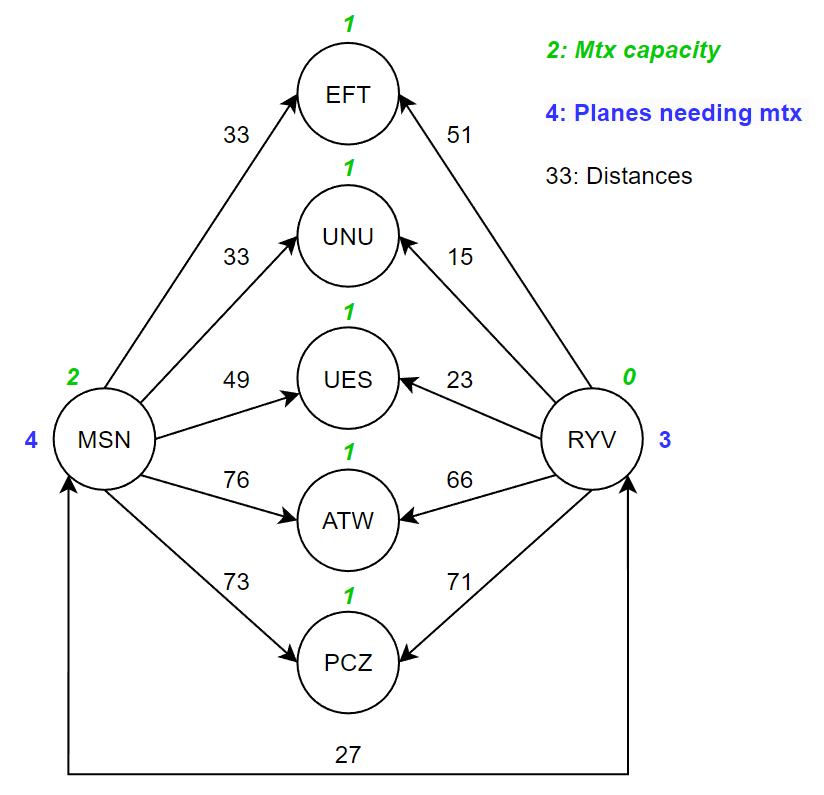

In [5]:
display("image/png", read("p03_network.png"))

In [6]:
using JuMP, Clp, NamedArrays

source = [:MSN, :RYV]
sink = [:MSN, :RYV, :EFT, :UNU, :UES, :ATW, :PCZ]

# create a NamedArray with indices of Sources (rows) and Sinks (columns).
# Elements are distances.
X = [0 27 33 33 49 76 73; 27 0 51 15 23 66 71]
dist = NamedArray(X, (source, sink), ("Sources", "Sinks"))
# each source has a # of planes
supply = Dict(zip(source, [4 3] ))
# each sink has a max # of capacity
demand = Dict(zip(sink, [2 0 1 1 1 1 1]))

m = Model(Clp.Optimizer)
# x[i,j] is number of planes sent from source i to sink j
@variable(m, x[source, sink] >= 0)

@constraint(m, sup[i in source], sum(x[i,j] for j in sink) == supply[i] )   # supply constraint
@constraint(m, dem[j in sink], sum(x[i,j] for i in source) == demand[j] )   # demand constraint

# minimize distances
@objective(m, Min, sum(x[i,j]*dist[i,j] for i in source, j in sink)) 

# solve this instance of the trasportation problem
optimize!(m)

println("Total distance will be ", objective_value(m))
solution = NamedArray( 
    Int[value(x[i,j]) for i in source, j in sink], 
    (source, sink), 
    ("Sources","Sinks") 
)

Total distance will be 210.0
Coin0506I Presolve 2 (-7) rows, 6 (-8) columns and 12 (-16) elements
Clp0006I 0  Obj 280 Primal inf 7.999998 (2) Dual inf 44.999998 (2)
Clp0006I 1  Obj 210
Clp0000I Optimal - objective value 210
Coin0511I After Postsolve, objective 210, infeasibilities - dual 0 (0), primal 0 (0)
Clp0032I Optimal objective 210 - 1 iterations time 0.002, Presolve 0.00


2×7 Named Matrix{Int64}
Sources ╲ Sinks │ MSN  RYV  EFT  UNU  UES  ATW  PCZ
────────────────┼──────────────────────────────────
MSN             │   2    0    1    0    0    0    1
RYV             │   0    0    0    1    1    1    0

## Problem 4 - Shortest path modeling

Start with the number 6. At each step, you can apply one of 3 operations to the current number:
* subtract 1
* multiply by 2
* add 3  

**What is the minimal number of operations (steps) needed to get from 6 to 2024?**


In [7]:
using JuMP, Clp, NamedArrays

arcs_sub1 = []
arcs_mul2 = []
arcs_add3 = []

nodes = 6: 2024
# nodes = :6: :2024
# println(nodes)
len_nodes = length(nodes)
# print(length(nodes))
# steps = Dict(zip(nodes, ones(2019,1)))

for i in nodes
    if i - 1 >= 6
        append!(arcs_sub1,[(i,i-1)])
    end
    if i * 2 <= 2024
        append!(arcs_mul2,[(i, i * 2)])
    end
    if i + 3 <= 2024
        append!(arcs_add3,[(i, i + 3)])
    end
end

# Combine all arcs
arcs = vcat(arcs_sub1, arcs_mul2, arcs_add3)
# println(arcs)
zero_list = zeros(len_nodes, len_nodes)
prec_list = NamedArray(zero_list, (nodes, nodes), ("from_node", "to_node"))
for i in arcs
    # println("i[1]: ", i[1], ", i[2]: ",i[2])
    prec_list[i[1] - 5, i[2] - 5] = 1
end

# prec_list[:7, :6]
# prec_list

m = Model(Clp.Optimizer)

@variable(m, x[nodes] >= 0) # variable for the step numbers we arrive each node

# create constraint for every pair of nodes (i,j) where node j is preceded by node i
@constraint(m, con_prec[i in nodes, j in nodes; prec_list[i-5,j-5] == 1], x[j] >= x[i] + 1)

# minimize the step we arrive node 2024 (finish)
@objective(m, Min, x[:2024])

# solve this isntance of the longest path problem
optimize!(m)
# record the value of the variables
xsol = value.(x)

println("Earliest completion is in ", objective_value(m), " steps")
for i in nodes
    println("Arrive Node ", i , " at step ", xsol[i])
end

Coin0506I Presolve 5039 (-2) rows, 2017 (-2) columns and 10078 (-4) elements
Clp0006I 0  Obj 683.89766 Primal inf 2691.0043 (4034)
Clp0006I 18  Obj 683.89766 Primal inf 2762.0042 (4013)
Clp0006I 21  Obj 683.89766 Primal inf 2772.0042 (4009)
Clp0006I 28  Obj 683.89766 Primal inf 2800.0042 (4002)
Clp0006I 33  Obj 683.89766 Primal inf 2818.0042 (3996)
Clp0006I 44  Obj 683.89766 Primal inf 2862.0042 (3985)
Clp0006I 49  Obj 683.89766 Primal inf 2882.0042 (3980)
Clp0006I 52  Obj 683.89766 Primal inf 2894.0042 (3977)
Clp0006I 55  Obj 683.89766 Primal inf 2906.0042 (3974)
Clp0001I Primal infeasible - objective value 683.89766
Clp0032I PrimalInfeasible objective 683.8976641 - 55 iterations time 0.012


LoadError: Primal solution not available